# Exploratory Data Analysis (EDA) on Traffic Prediction Dataset

In this notebook, we will perform exploratory data analysis on the Kaggle Traffic Prediction dataset. The analysis will include visualizations of traffic trends, junction-wise distribution, and time-series patterns.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Set visualisation style
sns.set(style='whitegrid')

# Load the dataset
data = pd.read_csv('traffic.csv')  # Update with the correct file path

# Display the first few rows of the dataset
data.head()

,DateTime,Junction,Vehicles,ID
0,2015-11-01 00:00:00,1,15,20151101001
1,2015-11-01 01:00:00,1,13,20151101011
2,2015-11-01 02:00:00,1,10,20151101021
3,2015-11-01 03:00:00,1,7,20151101031
4,2015-11-01 04:00:00,1,9,20151101041


In [2]:
# Replace 'DateTime' with your actual column name
data['DateTime'] = pd.to_datetime(data['DateTime'])
data.set_index('DateTime', inplace=True)

In [3]:
missing_values = data.isnull().sum()
print(missing_values[missing_values > 0])

Series([], dtype: int64)


C:\Users\swaya\AppData\Local\Temp\ipykernel_15244\1833746121.py:2: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  data['Vehicles'].resample('H').mean().plot()


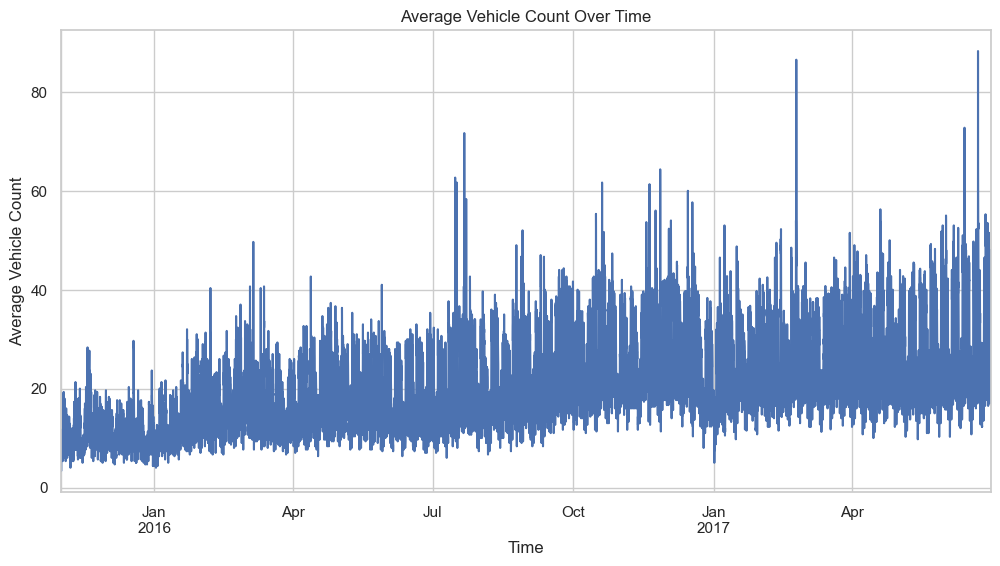

In [4]:
plt.figure(figsize=(12, 6))
data['Vehicles'].resample('H').mean().plot()
plt.title('Average Vehicle Count Over Time')
plt.xlabel('Time')
plt.ylabel('Average Vehicle Count')
plt.show()

C:\Users\swaya\AppData\Local\Temp\ipykernel_15244\1833746121.py:2: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  data['Vehicles'].resample('H').mean().plot()


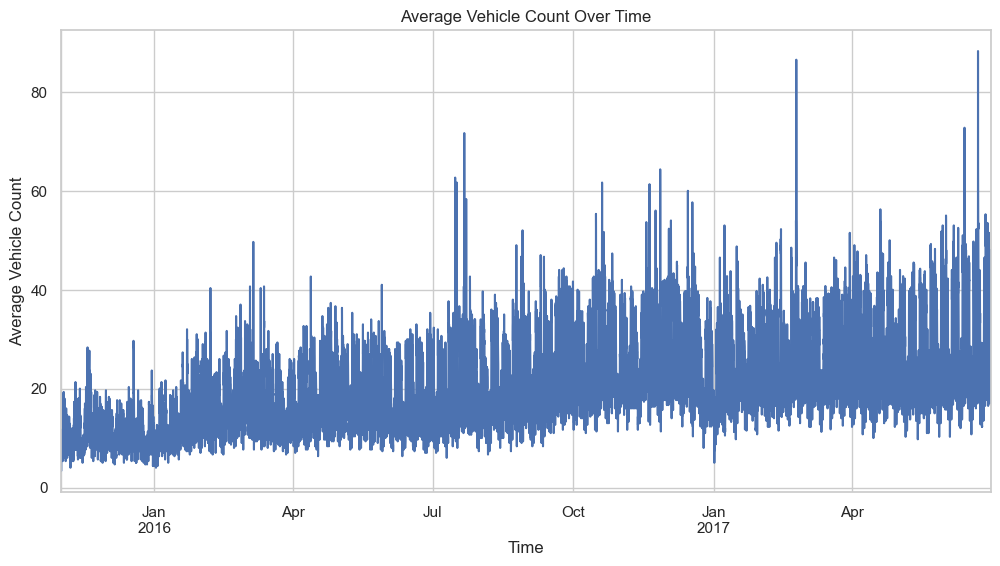

In [5]:
plt.figure(figsize=(12, 6))
data['Vehicles'].resample('H').mean().plot()
plt.title('Average Vehicle Count Over Time')
plt.xlabel('Time')
plt.ylabel('Average Vehicle Count')
plt.show()

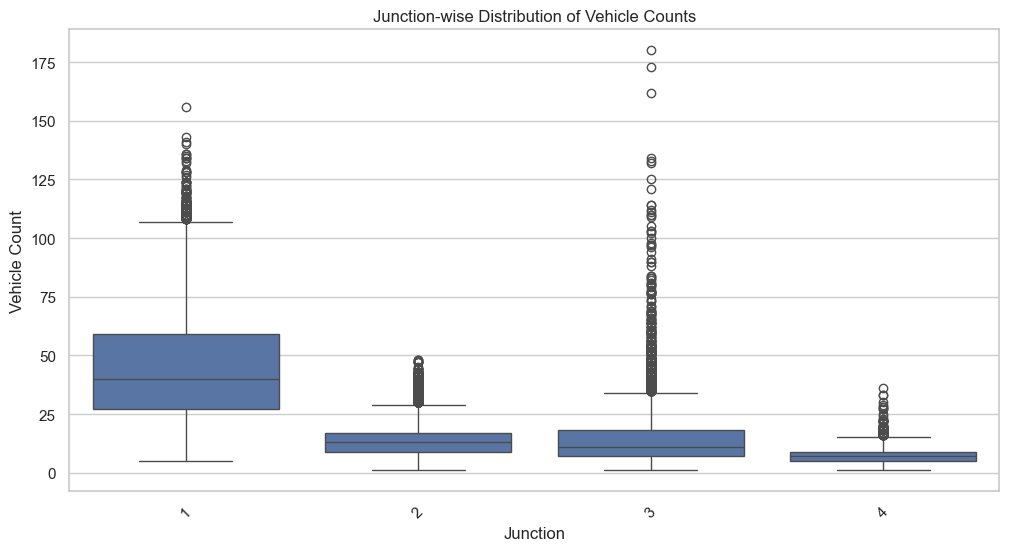

In [6]:
plt.figure(figsize=(12, 6))
sns.boxplot(x='Junction', y='Vehicles', data=data.reset_index())
plt.title('Junction-wise Distribution of Vehicle Counts')
plt.xlabel('Junction')
plt.ylabel('Vehicle Count')
plt.xticks(rotation=45)
plt.show()

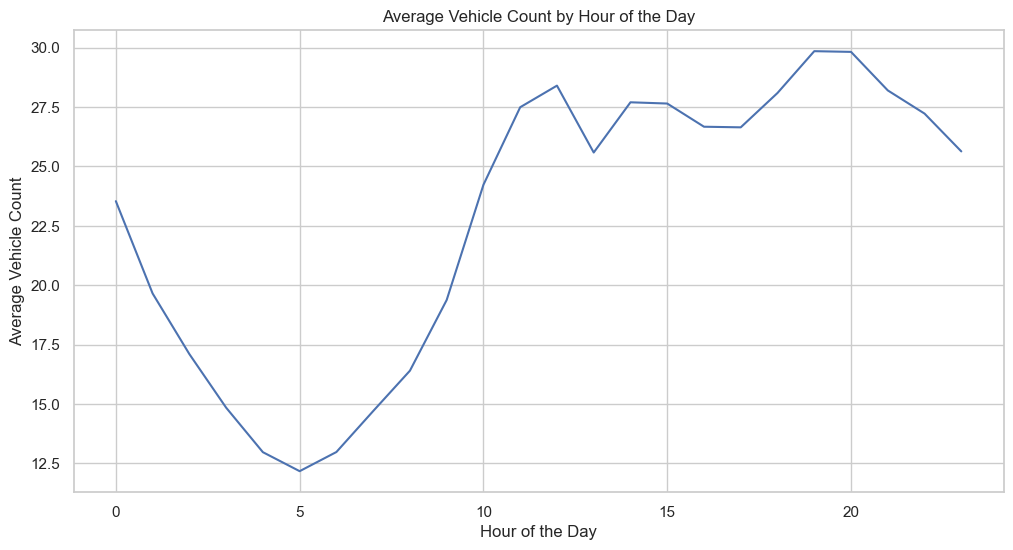

In [7]:
data['hour'] = data.index.hour
plt.figure(figsize=(12, 6))
sns.lineplot(x='hour', y='Vehicles', data=data.groupby('hour')['Vehicles'].mean().reset_index())
plt.title('Average Vehicle Count by Hour of the Day')
plt.xlabel('Hour of the Day')
plt.ylabel('Average Vehicle Count')
plt.show()

In [8]:
from sklearn.preprocessing import LabelEncoder
import numpy as np

# Extract time features
data['Year'] = data.index.year
data['Month'] = data.index.month
data['Day'] = data.index.day
data['Hour'] = data.index.hour
data['Weekday'] = data.index.weekday

# Cyclic encoding for Hour and Weekday
data['Hour_sin'] = np.sin(2 * np.pi * data['Hour']/24)
data['Hour_cos'] = np.cos(2 * np.pi * data['Hour']/24)
data['Weekday_sin'] = np.sin(2 * np.pi * data['Weekday']/7)
data['Weekday_cos'] = np.cos(2 * np.pi * data['Weekday']/7)


In [9]:
le = LabelEncoder()
data['Junction_enc'] = le.fit_transform(data['Junction'])

# Prepare features and target
features = ['Junction_enc', 'Year', 'Month', 'Day', 'Hour', 'Weekday', 'Hour_sin', 'Hour_cos', 'Weekday_sin', 'Weekday_cos']
X = data[features]
y = data['Vehicles']

In [10]:
# Train/Test Split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [11]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

In [12]:
models = {
    'LinearRegression': LinearRegression(),
    'RandomForest': RandomForestRegressor(n_estimators=100, random_state=42),
    'XGBoost': XGBRegressor(n_estimators=100, random_state=42)
}

In [13]:
results = {}
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    # Evaluation
    from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
    rmse = mean_squared_error(y_test, y_pred, squared=False)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    results[name] = {'rmse': rmse, 'mae': mae, 'r2': r2}
    print(f"{name}: RMSE={rmse:.2f}, MAE={mae:.2f}, R2={r2:.2f}")


c:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


LinearRegression: RMSE=12.35, MAE=9.30, R2=0.63


c:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


RandomForest: RMSE=3.57, MAE=2.41, R2=0.97
XGBoost: RMSE=4.33, MAE=2.66, R2=0.95


c:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [14]:
best_model_name = max(results, key=lambda k: results[k]['r2'])
best_model = models[best_model_name]
print(f"Best model: {best_model_name}")

Best model: RandomForest


In [15]:
import joblib
import os

# Define path
model_dir = "../models"
os.makedirs(model_dir, exist_ok=True)   # create folder if it doesn't exist

# Save model
joblib.dump(best_model, f"{model_dir}/{best_model_name}_traffic_model.pkl")


['../models/RandomForest_traffic_model.pkl']

In [16]:
sample = X_test.iloc[0:1]
pred = best_model.predict(sample)
print("Sample input:", sample)
print("Predicted vehicle count:", int(pred[0]))
print("Actual vehicle count:", int(y_test.iloc[0]))

Sample input:                      Junction_enc  Year  Month  Day  Hour  Weekday  Hour_sin  \
DateTime                                                                       
2016-12-23 08:00:00             1  2016     12   23     8        4  0.866025   

                     Hour_cos  Weekday_sin  Weekday_cos  
DateTime                                                 
2016-12-23 08:00:00      -0.5    -0.433884    -0.900969  
Predicted vehicle count: 9
Actual vehicle count: 9
